# SETTINGS

In [1]:
########## LIBRARIES

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import os
import time
import datetime
import random
import multiprocessing
import pickle
import warnings
import gc
from tqdm import tqdm

In [2]:
########## HELPER FUNCTIONS

!pip install --upgrade dptools
from dptools import *

Requirement already up-to-date: dptools in /Users/kozodoi/miniconda3/envs/py3/lib/python3.7/site-packages (0.3.5)


In [3]:
########## SETTINGS

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('dark_background')
%matplotlib inline
gc.enable()

# DATA IMPORT

In [4]:
# read data
orders = pd.read_csv('../data/prepared/orders_v1.csv', compression = 'gzip')
items  = pd.read_csv('../data/prepared/items_v1.csv',  compression = 'gzip')
print(orders.shape)
print(items.shape)

(2181955, 5)
(10463, 12)


In [5]:
# convert dates
orders['time']       = pd.to_datetime(orders['time'].astype('str'),       infer_datetime_format = True)
items['promotion_0'] = pd.to_datetime(items['promotion_0'].astype('str'), infer_datetime_format = True)
items['promotion_1'] = pd.to_datetime(items['promotion_1'].astype('str'), infer_datetime_format = True)
items['promotion_2'] = pd.to_datetime(items['promotion_2'].astype('str'), infer_datetime_format = True)

# ADD FEATURES: ITEMS

In [6]:
# price ratio
items['price_ratio'] = items['simulationPrice'] / items['recommendedRetailPrice']
items['price_ratio'].describe()

count    10463.000000
mean         0.957107
std          0.616878
min          0.020094
25%          0.449184
50%          0.813378
75%          1.359211
max          5.678983
Name: price_ratio, dtype: float64

# ADD FEATURES: ORDERS

In [7]:
# total orders
print(orders['order'].sum())

2715559


In [8]:
##### AGGREGATE ORDERS BY DAY

# this currently leads to loosing other features in orders.csv
# TODO: integrate the remaining features here and in the cells below

# aggregation
orders['day_of_year'] = orders['time'].dt.dayofyear
orders = orders.groupby(['itemID', 'day_of_year'])['order'].agg('sum').reset_index()
orders.head()

,itemID,day_of_year,order
0,1,23,1
1,1,25,1
2,1,29,307
3,1,30,3
4,1,31,1


In [9]:
# check total orders
print(orders['order'].sum())

2715559


In [10]:
##### FIND PROMOTION DAYS

# documentation says that we have to manually mark promotion days in the training period
# without marking, predictions are difficult because orders in some daye explode without apparent reason
# for now, I treat promotions as days when the number of orders for a given item exceeds 90th percentile
# we need to be very careful with threshold and rely on visuzal analysis and/or better metric to mark promos

# computations
orders['promotion'] = 0
for itemID in tqdm(orders['itemID'].unique()):
    promo_quant = orders[orders['itemID'] == itemID]['order'].quantile(0.90)
    orders.loc[(orders['itemID'] == itemID) & (orders['order'] >= promo_quant), 'promotion'] = 1

# check total promotions
print(orders['promotion'].sum())

100%|██████████| 9840/9840 [02:29<00:00, 65.79it/s]

18143


In [11]:
##### ADD MISSING INPUTS

# add items that were never sold before
missing_itemIDs = set(items['itemID'].unique()) - set(orders['itemID'].unique())
missing_rows = pd.DataFrame({'itemID':     list(missing_itemIDs), 
                            'day_of_year': np.ones(len(missing_itemIDs)).astype('int'), 
                            'order':       np.zeros(len(missing_itemIDs)).astype('int')})
orders = pd.concat([orders, missing_rows], axis = 0)
print(orders.shape)

# add zeros for days with no transactions
agg_orders = orders.groupby(['itemID', 'day_of_year']).order.unique().unstack('day_of_year').stack('day_of_year', dropna = False)
agg_orders = agg_orders.reset_index()
agg_orders.columns = ['itemID', 'day_of_year', 'order']
agg_orders['order'].fillna(0, inplace = True)
agg_orders['order'] = agg_orders['order'].astype(int)
agg_orders = agg_orders.merge(orders[['itemID', 'day_of_year', 'promotion']], how = 'left')
agg_orders['promotion'].fillna(0, inplace = True)
agg_orders['promotion'] = agg_orders['promotion'].astype(int)
print(agg_orders.shape)

(100771, 4)
(1883340, 4)


In [12]:
# check total orders
print(agg_orders['order'].sum())

2715559


Text(0.5, 0, 'Day')

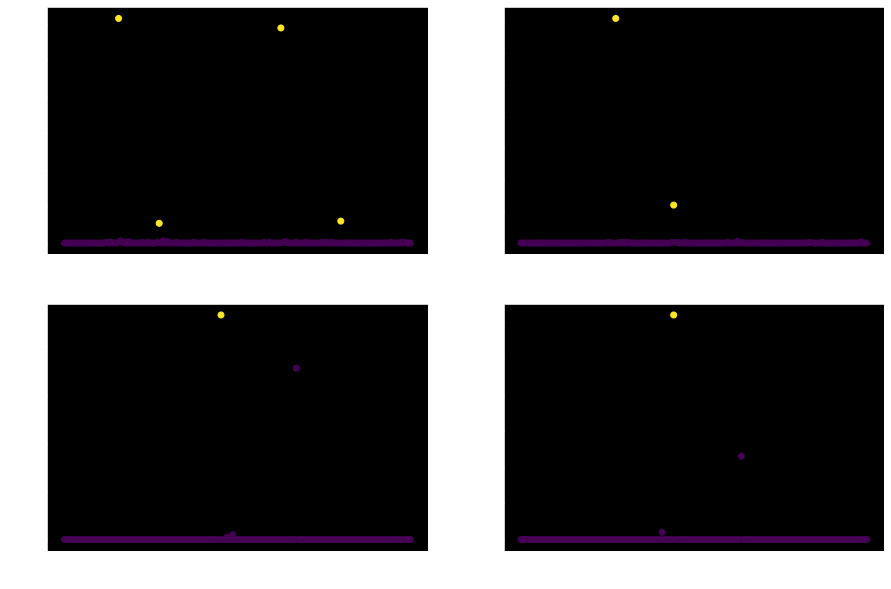

In [13]:
### EXAMPLE SALES PLOT

fig = plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
df = agg_orders[agg_orders.itemID == 1]
plt.scatter(df['day_of_year'], df['order'], c = df['promotion'])
plt.ylabel('Total Orders')
plt.xlabel('Day')

plt.subplot(2, 2, 2)
df = agg_orders[agg_orders.itemID == 10]
plt.scatter(df['day_of_year'], df['order'], c = df['promotion'])
plt.ylabel('Total Orders')
plt.xlabel('Day')

plt.subplot(2, 2, 3)
df = agg_orders[agg_orders.itemID == 100]
plt.scatter(df['day_of_year'], df['order'], c = df['promotion'])
plt.ylabel('Total Orders')
plt.xlabel('Day')

plt.subplot(2, 2, 4)
df = agg_orders[agg_orders.itemID == 1000]
plt.scatter(df['day_of_year'], df['order'], c = df['promotion'])
plt.ylabel('Total Orders')
plt.xlabel('Day')

In [14]:
##### COMPUTING TARGETS AND FEATURES

# parameters
days_input  = [7, 14, 21, 28]
days_target = 14

# preparations
day_first = np.max(days_input)
day_last  = agg_orders['day_of_year'].max() - days_target
orders    = None

# computations
for day_of_year in tqdm(range(day_first, day_last)):
                
    ##### TARGET AND PROMOTION
        
    # day intervals
    target_day_min = day_of_year + 1
    target_day_max = day_of_year + days_target
    
    # compute target and promotion
    if day_of_year < agg_orders['day_of_year'].max():
        
        # days in training data
        tmp_df = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                            (agg_orders['day_of_year'] <= target_day_max)
                           ].groupby('itemID')['order', 'promotion'].agg('sum').reset_index()
        tmp_df.columns = ['itemID', 'target', 'promo_in_test']
        
    else:
        
        # day in test data
        tmp_df = agg_orders[agg_orders['day_of_year'] == day_of_year].groupby('itemID')['order', 'promotion'].agg('sum').reset_index()
        tmp_df.columns = ['itemID', 'target', 'promo_in_test']        
        tmp_df['target'] = np.nan
        
        
    ##### FEATURES
        
    # compute features
    for day_input in days_input:
        
        # day intervals
        input_day_min  = day_of_year - day_input + 1
        input_day_max  = day_of_year
    
        # frequency
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('itemID')
        tmp_df['order_sum_last_'   + str(day_input)] = tmp_df_input['order'].agg('sum').reset_index()['order']
        tmp_df['order_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df['promo_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
                
        # overall order and promo count (all items)
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)]
        tmp_df['all_orders_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0]))
        tmp_df['all_promos_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum')

        # recency
        if day_input == max(days_input):
            tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                      (agg_orders['day_of_year'] <= input_day_max) &
                                      (agg_orders['order'] > 0)
                                     ].groupby('itemID')
            tmp_df['days_since_last_order'] = (day_of_year - tmp_df_input['day_of_year'].agg('max')).reindex(tmp_df.itemID).reset_index()['day_of_year']
            tmp_df['days_since_last_order'].fillna(day_input, inplace = True)
        
    # add day of year
    tmp_df.insert(1, column = 'day_of_year', value = day_of_year)
        
    # merge data
    orders = pd.concat([orders, tmp_df], axis = 0)

100%|██████████| 138/138 [45:11<00:00, 19.65s/it]


Text(0.5, 0, 'Day')

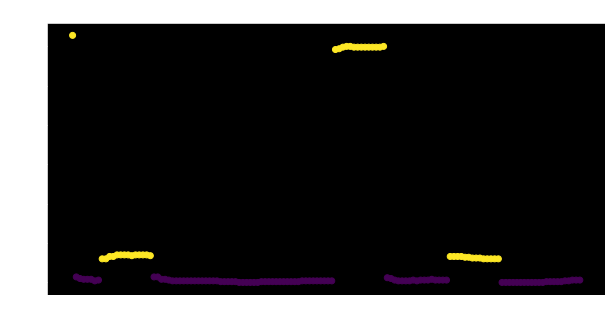

In [15]:
# example sales plot
df = orders[orders.itemID == 1]
plt.figure(figsize = (10, 5))
plt.scatter(df['day_of_year'], df['target'], c = df['promo_in_test'])
plt.title('itemID == 1')
plt.ylabel('Target (orders in next 14 days)')
plt.xlabel('Day')

# MERGE DATA SETS

In [16]:
print(orders.shape)
print(items.shape)
df = pd.merge(orders, items, on = 'itemID', how = 'left')
print(df.shape)

(1443894, 25)
(10463, 13)
(1443894, 37)


# EXTRACT TEST DATA

In [17]:
# partition intro train and test
df_train = df[df['day_of_year'] <  df['day_of_year'].max()]
df_test  = df[df['day_of_year'] == df['day_of_year'].max()]
print(df_train.shape)
print(df_test.shape)

(1433431, 37)
(10463, 37)


In [18]:
# add promotion info to test
promo_vars = df_test.filter(like = 'promotion_').columns
df_test['promo_in_test'] = 3 - df_test[promo_vars].isnull().sum(axis = 1)
df_test['promo_in_test'].describe()

# drop promotion dates
df_test.drop(promo_vars,  axis = 1, inplace = True)
df_train.drop(promo_vars, axis = 1, inplace = True)
print(df_train.shape)
print(df_test.shape)

(1433431, 34)
(10463, 34)


# EXPORT

In [19]:
##### LOGS

# data (shape): descriprion
#
# df_v1 (1357920, 23): first aggregated df version with 4x2 lagged frequency-based features [7,14,21,28 days]
# df_v2 (1357920, 24): added promo_in_test feature using 0.9 percentile of item-specific demand
# df_v3 (1433431, 21): added rows with missing itemIDs for items that were never sold during training period;
#                      added test sample with NA target and promo_in_test feature
#                      removed promotion_i features info from training data
# df_v4 (1433431, 26): added promo_count features; added days_since_last_order with NA set to time horizon
# df_v5 (1433431, 34): added all_promo_count and all_order_count features for aggregated stats on all items

In [20]:
# save data frame
# save_csv_version() automatically adds version number to prevent overwriting
save_csv_version('../data/prepared/df.csv',      df_train, index = False, compression = 'gzip')
save_csv_version('../data/prepared/df_test.csv', df_test,  index = False, compression = 'gzip', min_version = 3)
print(df_train.shape)
print(df_test.shape)

Saved as ../data/prepared/df_v5.csv
Saved as ../data/prepared/df_test_v5.csv
(1433431, 34)
(10463, 34)
